In [70]:
## Variables

In [71]:
srr_name <- "SRR5090599"
donor_name <- "hpv16"
recipient_name <- "USCShg38"
inputs_folder <- "notebook_test_data/"
donor_ref_genome <- "../../wallaby/data/ref_genomes/hpv/HPV16.fasta"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/USCS.hg38.fasta"

In [ ]:
# Parameters
srr_name = "SRR5090599"
donor_name = "hpv16"
recipient_name = "USCShg38"
inputs_folder = "notebook_test_data/"
donor_ref_genome = "../../wallaby/data/ref_genomes/hpv/HPV16.fasta"
recipient_ref_genome = "../../wallaby/data/ref_genomes/human/USCS.hg38.fasta"


# Tertiary analysis of a Donor-to-Recipient pipeline

In [72]:
## Setup Environment

In [73]:
# Enable multithreading when possible (library dependent)
options(Ncpus = parallel::detectCores())
Sys.setenv(OMP_NUM_THREADS=toString(parallel::detectCores()))
Sys.setenv(OMP_THREAD_LIMIT=toString(parallel::detectCores()))
Sys.setenv(OMP_NUM_THREADS=parallel::detectCores())
Sys.setenv(OMP_THREAD_LIMIT=parallel::detectCores())

# Installing base libraries  
suppressPackageStartupMessages(library("pacman", character.only = TRUE))
suppressPackageStartupMessages(library("BiocManager", character.only = TRUE))
suppressPackageStartupMessages(library("XML", character.only = TRUE))

# Longer tables
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

# List of CRAN packages to either Load, or Install and Load
pacman::p_load(dplyr, 
               ggplot2,
               shiny,
               shinyLP,
               DT, 
               ggrepel, 
               tidyr,
               data.table)

# List of Bioconductor packages to either Load, or Install and Load
pacman::p_load(GenomicAlignments, 
               Rsubread, 
               Rsamtools,
               bamsignals, 
               rtracklayer,
               GenomicRanges,
               regioneR,
               karyoploteR, 
               seqinr,
               Repitools)

message('Libraries Loaded')

Libraries Loaded



In [74]:
## Helper Functions

In [105]:
donor_viz <- function(donor_ref_genome, reads_to_donor_MUd_UMr.bed.gr, reads_to_donor_UMd_MUr.bed.gr) {
    # Read donor fasta file and calculate total organism length,
    # adding up all possible separate segments in genome
    summary_fasta <- summary(read.fasta(donor_ref_genome))
    summary_fasta_lengths <- summary_fasta[, "Length"]
    sequence_sum <- c()
    for (item in c(1,length(summary_fasta_lengths))) { sequence_sum <- c(sequence_sum, strtoi(summary_fasta_lengths[[item]])) }
    total_genome_length <- sum(sequence_sum)
    
    # Extract sequence name
    seqname <- unique(as.character(seqnames(reads_to_donor_MMd_MMr.bed.gr)))
    
    # Build a custom GRanges for the donor genome
    custom.genome <- toGRanges(data.frame(chr=c(seqname), start=c(1), end=c(total_genome_length)))
    
    # Plot MU_UM and UM_MU reads on the donor genome
    options(repr.plot.width=30, repr.plot.height=10)

    plot.type <- 4
    tracks <- 2
    track_sep <- 0.1
    track_width <- 1/(tracks+tracks*track_sep)
    window.size <- ceiling(total_genome_length/100) # averaged every # reads in window
    print(paste("Window size for density calculation, in (kb): ", window.size))
    genome = custom.genome

    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.13
    kp <- plotKaryotype(genome=genome, plot.type = plot.type, plot.params = pp, labels.plotter = NULL)
    kpAddBaseNumbers(kp, tick.dist = window.size*50, add.units = TRUE)
    kpAddChromosomeNames(kp, yoffset = -10)

    track_no=1
    r0 <- (track_no-1)*track_width+(track_no-1)*track_sep
    r1 <- track_no*track_width+(track_no-1)*track_sep
    kp <- suppressWarnings(kpPlotDensity(kp, data=reads_to_donor_MUd_UMr.bed.gr, window.size = window.size, col="blue", r0=r0, r1=r1))
    kpAxis(kp, ymax=kp$latest.plot$computed.values$max.density, cex=0.8, r0=r0, r1=r1)
    kpAddLabels(kp, labels = "donor_MUd_UMr", r0=r0, r1=r1, label.margin = 0.04)

    track_no=2
    r0 <- (track_no-1)*track_width+(track_no-1)*track_sep
    r1 <- track_no*track_width+(track_no-1)*track_sep
    kp <- suppressWarnings(kpPlotDensity(kp, data=reads_to_donor_UMd_MUr.bed.gr, window.size = window.size, col="red", r0=r0, r1=r1))
    kpAxis(kp, ymax=kp$latest.plot$computed.values$max.density, cex=0.8, r0=r0, r1=r1)
    kpAddLabels(kp, labels = "donor_UMd_MUr", r0=r0, r1=r1, label.margin = 0.04)
}
recipient_viz <- function(reads_to_recipient_MUd_UMr.bed.gr, reads_to_recipient_UMd_MUr.bed.gr) {
    options(repr.plot.width=30, repr.plot.height=15)

    plot.type <- 4
    tracks <- 2
    track_sep <- 0.1
    track_width <- 1/(tracks+tracks*0.05)
    window.size <- 1e6 # averaged every # reads in window
    print(paste("Window size for density calculation, in (kb): ", window.size))
    genome = "hg38"

    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.13
    kp <- plotKaryotype(genome=genome, plot.type = plot.type, plot.params = pp, labels.plotter = NULL)
    kpAddChromosomeNames(kp, srt=45)

    track_no=1
    r0 <- (track_no-1)*track_width+(track_no-1)*track_sep
    r1 <- track_no*track_width+(track_no-1)*track_sep
    kp <- suppressWarnings(kpPlotDensity(kp, data=reads_to_recipient_MUd_UMr.bed.gr, window.size = window.size, col="blue", r0=r0, r1=r1))
    kpAxis(kp, ymax=kp$latest.plot$computed.values$max.density, cex=0.8, r0=r0, r1=r1)
    kpAddLabels(kp, labels = "recipient_MUd_UMr", r0=r0, r1=r1, label.margin = 0.04)

    track_no=2
    r0 <- (track_no-1)*track_width+(track_no-1)*track_sep
    r1 <- track_no*track_width+(track_no-1)*track_sep
    kp <- suppressWarnings(kpPlotDensity(kp, data=reads_to_recipient_UMd_MUr.bed.gr, window.size = window.size, col="red", r0=r0, r1=r1))
    kpAxis(kp, ymax=kp$latest.plot$computed.values$max.density, cex=0.8, r0=r0, r1=r1)
    kpAddLabels(kp, labels = "recipient_UMd_MUr", r0=r0, r1=r1, label.margin = 0.04)
}
single_donor_viz <- function(reads_to_donor, donor_ref_genome, label) {
    # Read donor fasta file and calculate total organism length,
    # adding up all possible separate segments in genome
    summary_fasta <- summary(read.fasta(donor_ref_genome))
    summary_fasta_lengths <- summary_fasta[, "Length"]
    sequence_sum <- c()
    for (item in c(1,length(summary_fasta_lengths))) { sequence_sum <- c(sequence_sum, strtoi(summary_fasta_lengths[[item]])) }
    total_genome_length <- sum(sequence_sum)
    
    # Extract sequence name
    seqname <- unique(as.character(seqnames(reads_to_donor)))
    
    # Build a custom GRanges for the donor genome
    custom.genome <- toGRanges(data.frame(chr=c(seqname), start=c(1), end=c(total_genome_length)))
    
    # Plot MU_UM and UM_MU reads on the donor genome
    options(repr.plot.width=30, repr.plot.height=6)

    plot.type <- 4
    window.size <- ceiling(total_genome_length/100) # averaged every # reads in window
    print(paste("Window size for density calculation, in (kb): ", window.size))
    genome = custom.genome

    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.13
    kp <- plotKaryotype(genome=genome, plot.type = plot.type, plot.params = pp, labels.plotter = NULL)
    kpAddBaseNumbers(kp, tick.dist = window.size*50, add.units = TRUE)
    kpAddChromosomeNames(kp, yoffset = -10)

    kp <- suppressWarnings(kpPlotDensity(kp, data=reads_to_donor, window.size = window.size, col="blue"))
    kpAxis(kp, ymax=kp$latest.plot$computed.values$max.density, cex=0.8)
    kpAddLabels(kp, labels = label, label.margin = 0.04)

}
print_summary_table <- function(bed_file, min_reads_count){
    granges <- bed_file
    granges_df <- annoGR2DF(granges)
    granges_dt <- as.data.table(granges_df)
    ## Interval per chromosome
    granges_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) },by=chr]
    ## Group by chromosome
    granges_final <- granges_dt[, list(start=min(start), stop=max(end), 
                                    number_of_reads=length(list(name)[[1]])
                                   ), by=list(group,chr)]
    print(paste('Minimum Reads Count = ', min_reads_count, sep = ""))
    granges_final[granges_final[, number_of_reads > (min_reads_count - 1)]]
}
message('Functions Created')

Functions Created



In [76]:
## Loading pipeline output files
# Try to open all files - note that some will not exists as that specific crossing bucket did not return any matches

In [77]:
# Variables to hold all file paths  
try(reads_to_donor_MMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MMr.bam", sep = ""))
try(reads_to_donor_MMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MUr.bam", sep = ""))
try(reads_to_donor_MMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UMr.bam", sep = ""))
try(reads_to_donor_MMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UUr.bam", sep = ""))
try(reads_to_donor_MUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MMr.bam", sep = ""))
try(reads_to_donor_MUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MUr.bam", sep = ""))
try(reads_to_donor_MUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UMr.bam", sep = ""))
try(reads_to_donor_MUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UUr.bam", sep = ""))
try(reads_to_donor_UMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MMr.bam", sep = ""))
try(reads_to_donor_UMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MUr.bam", sep = ""))
try(reads_to_donor_UMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UMr.bam", sep = ""))
try(reads_to_donor_UMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UUr.bam", sep = ""))
try(reads_to_donor_UUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MMr.bam", sep = ""))
try(reads_to_donor_UUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MUr.bam", sep = ""))
try(reads_to_donor_UUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UMr.bam", sep = ""))
try(reads_to_donor_UUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UUr.bam", sep = ""))

In [78]:
# Variables to hold all file paths  
try(reads_to_recipient_MMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MMr.bam", sep = ""))
try(reads_to_recipient_MMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MUr.bam", sep = ""))
try(reads_to_recipient_MMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UMr.bam", sep = ""))
try(reads_to_recipient_MMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UUr.bam", sep = ""))
try(reads_to_recipient_MUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MMr.bam", sep = ""))
try(reads_to_recipient_MUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MUr.bam", sep = ""))
try(reads_to_recipient_MUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UMr.bam", sep = ""))
try(reads_to_recipient_MUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UUr.bam", sep = ""))
try(reads_to_recipient_UMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MMr.bam", sep = ""))
try(reads_to_recipient_UMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MUr.bam", sep = ""))
try(reads_to_recipient_UMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UMr.bam", sep = ""))
try(reads_to_recipient_UMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UUr.bam", sep = ""))
try(reads_to_recipient_UUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MMr.bam", sep = ""))
try(reads_to_recipient_UUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MUr.bam", sep = ""))
try(reads_to_recipient_UUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UMr.bam", sep = ""))
try(reads_to_recipient_UUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UUr.bam", sep = ""))

In [79]:
message('Donor BAMs and BEDs loaded')

Donor BAMs and BEDs loaded



In [80]:
# Variables to hold all file paths  
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MMd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MMd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MMd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MMd_UUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MUd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MUd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MUd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_MUd_UUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UMd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UMd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UMd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UMd_UUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UUd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UUd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UUd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UUd_UUr.bed.gr <- import(file)}

In [81]:
# Variables to hold all file paths  
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MMd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MMd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MMd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MMd_UUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MUd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MUd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MUd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_MUd_UUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UMd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UMd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UMd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UMd_UUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UUd_MMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MUr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UUd_MUr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UMr.bed", sep = "")
if (file.exists(file)) {reads_to_recipient_UUd_UMr.bed.gr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UUr.bed", sep = "")
if (file.exists(file)) {reads_to_donor_UUd_UUr.bed.gr <- import(file)}

In [82]:
message('Recipient BAMs and BEDs loaded')

Recipient BAMs and BEDs loaded



## Visualization of read groups (crosses)

### reads_to_donor_MMd_UUr

[1] "Window size for density calculation, in (kb):  159"


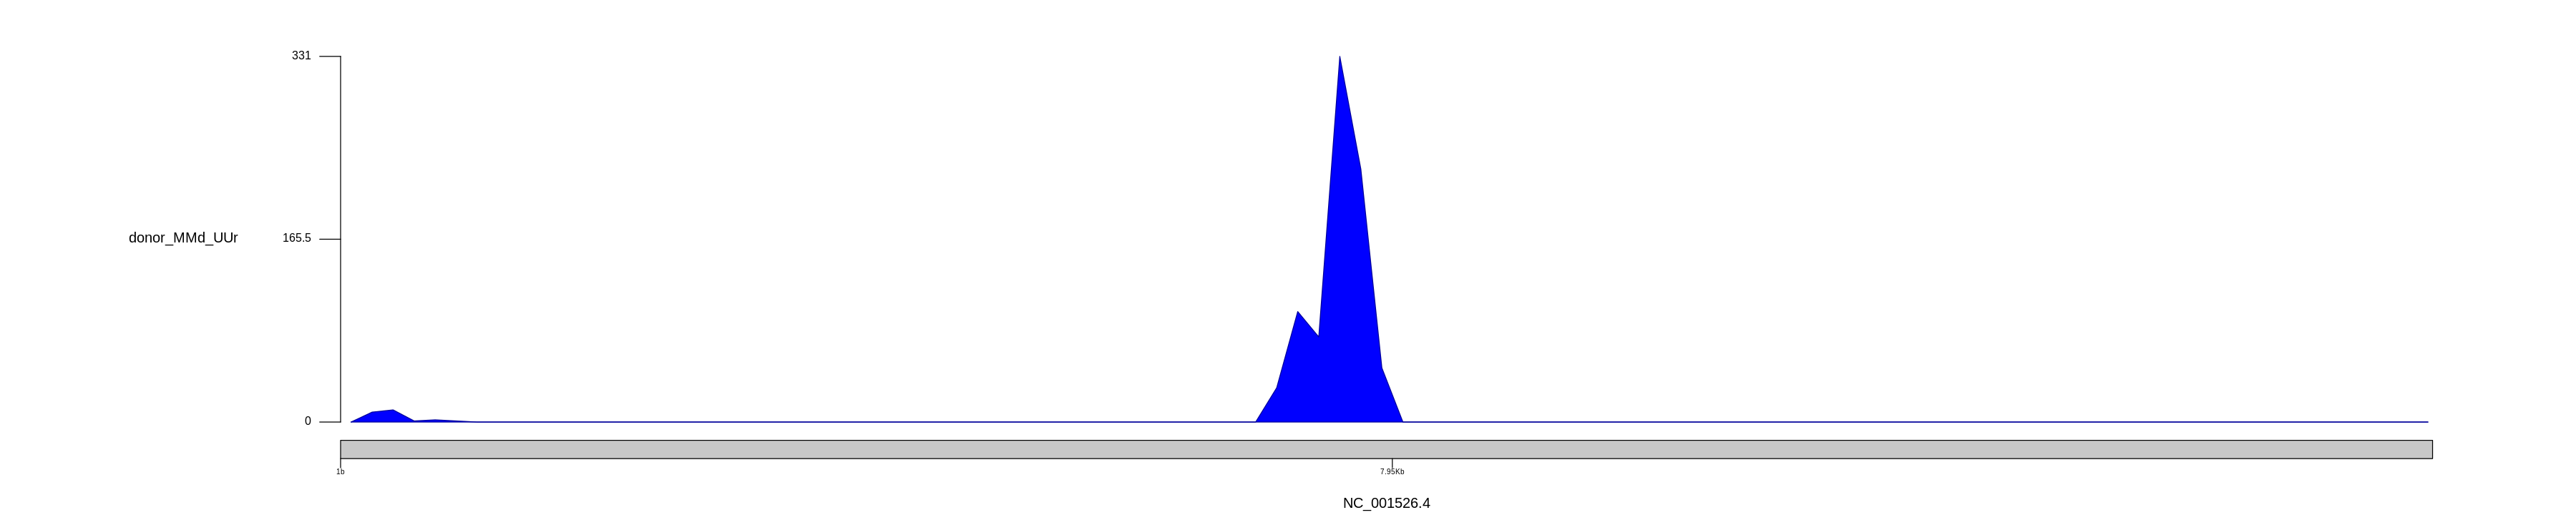

In [83]:
try(single_donor_viz(reads_to_donor_MMd_UUr.bed.gr, donor_ref_genome, label="donor_MMd_UUr"))

[1] "Window size for density calculation, in (kb):  159"


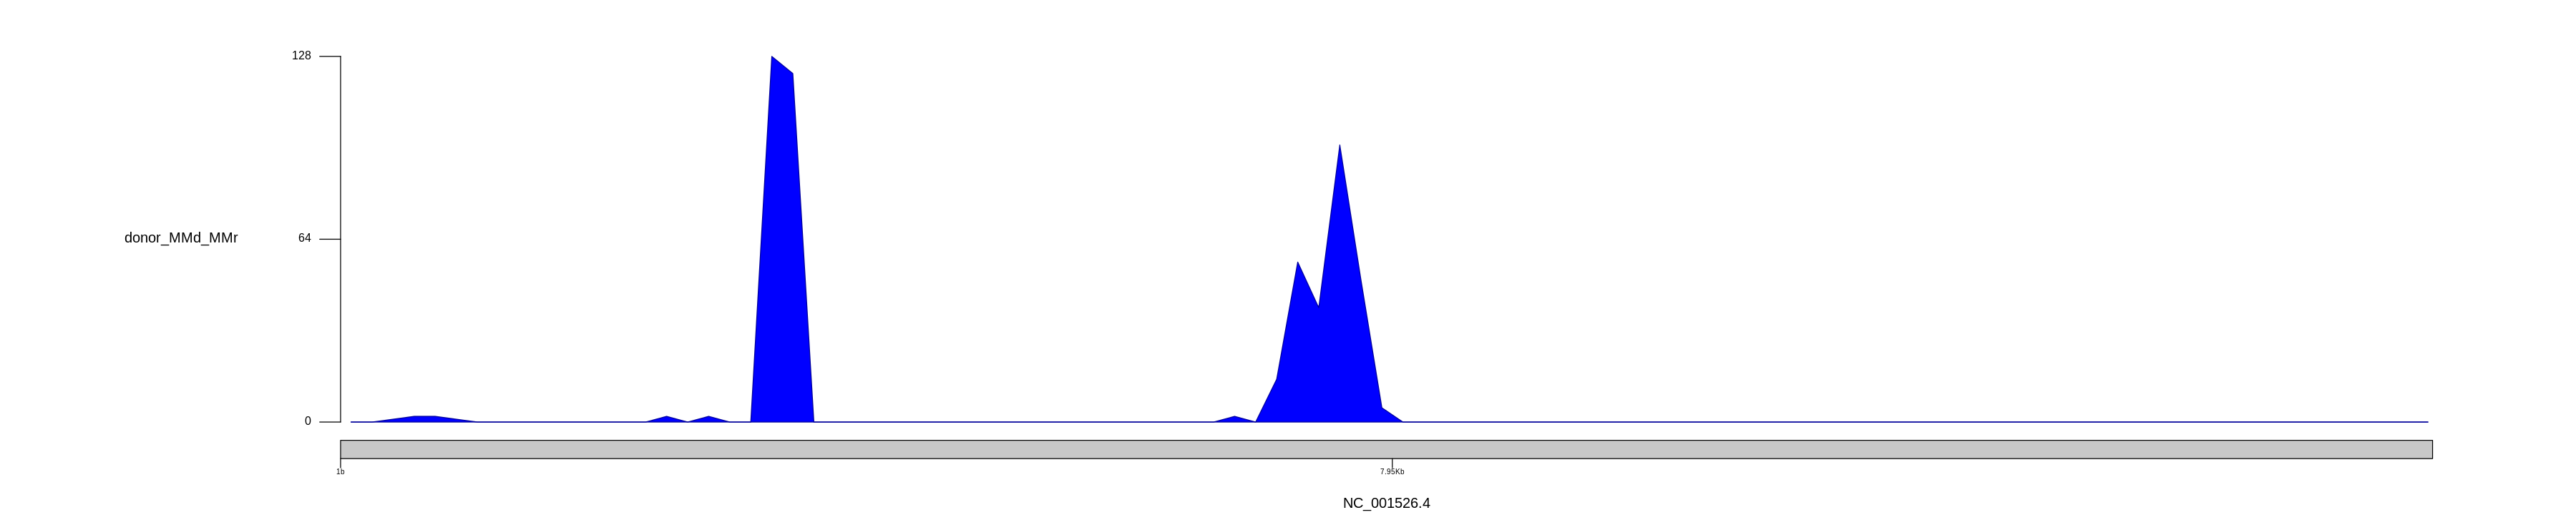

In [84]:
try(single_donor_viz(reads_to_donor_MMd_MMr.bed.gr, donor_ref_genome, label="donor_MMd_MMr"))

In [106]:
try(print_summary_table(reads_to_donor_MMd_UUr.bed.gr, min_reads_count = 2))

[1] "Minimum Reads Count = 2"


group,chr,start,stop,number_of_reads
<int>,<fct>,<int>,<int>,<int>
1,NC_001526.4,192,496,12
2,NC_001526.4,660,812,2
3,NC_001526.4,7074,7906,514


## Visualize reads in donor genome - reads_to_donor_MUd_UMr and reads_to_donor_UMd_MUr

[1] "Window size for density calculation, in (kb):  159"


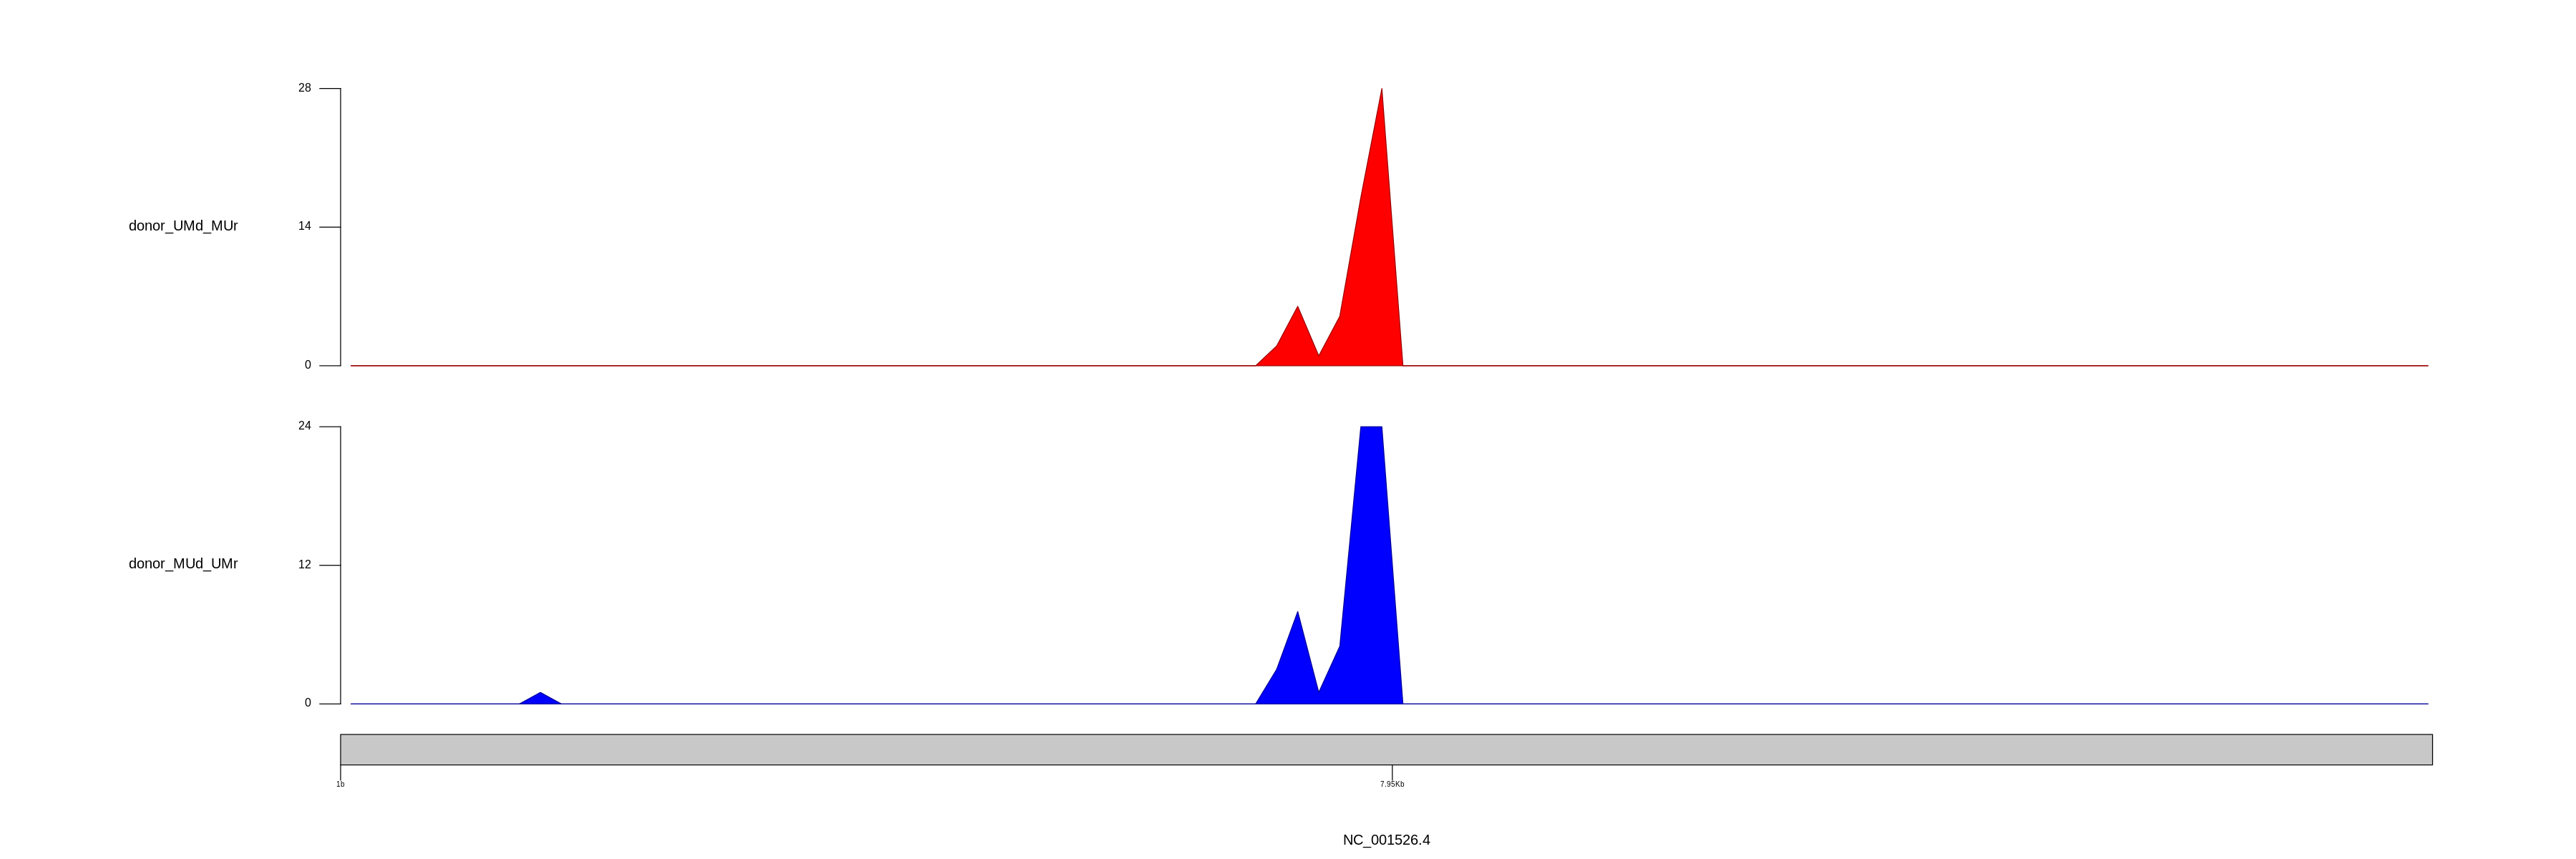

In [86]:
try(donor_viz(donor_ref_genome, reads_to_donor_MUd_UMr.bed.gr, reads_to_donor_UMd_MUr.bed.gr))

### reads_to_donor_MUd_UMr

In [107]:
try(print_summary_table(reads_to_donor_MUd_UMr.bed.gr, min_reads_count = 2))

[1] "Minimum Reads Count = 2"


group,chr,start,stop,number_of_reads
<int>,<fct>,<int>,<int>,<int>
2,NC_001526.4,7148,7271,8
3,NC_001526.4,7449,7906,35


### reads_to_donor_UMd_MUr

In [109]:
try(print_summary_table(reads_to_donor_UMd_MUr.bed.gr, min_reads_count = 2))

[1] "Minimum Reads Count = 2"


group,chr,start,stop,number_of_reads
<int>,<fct>,<int>,<int>,<int>
1,NC_001526.4,7153,7270,6
2,NC_001526.4,7449,7906,35


## Visualize reads in recipient genome - reads_to_recipient_UMd_MUr and reads_to_recipient_MUd_UMr

[1] "Window size for density calculation, in (kb):  1e+06"


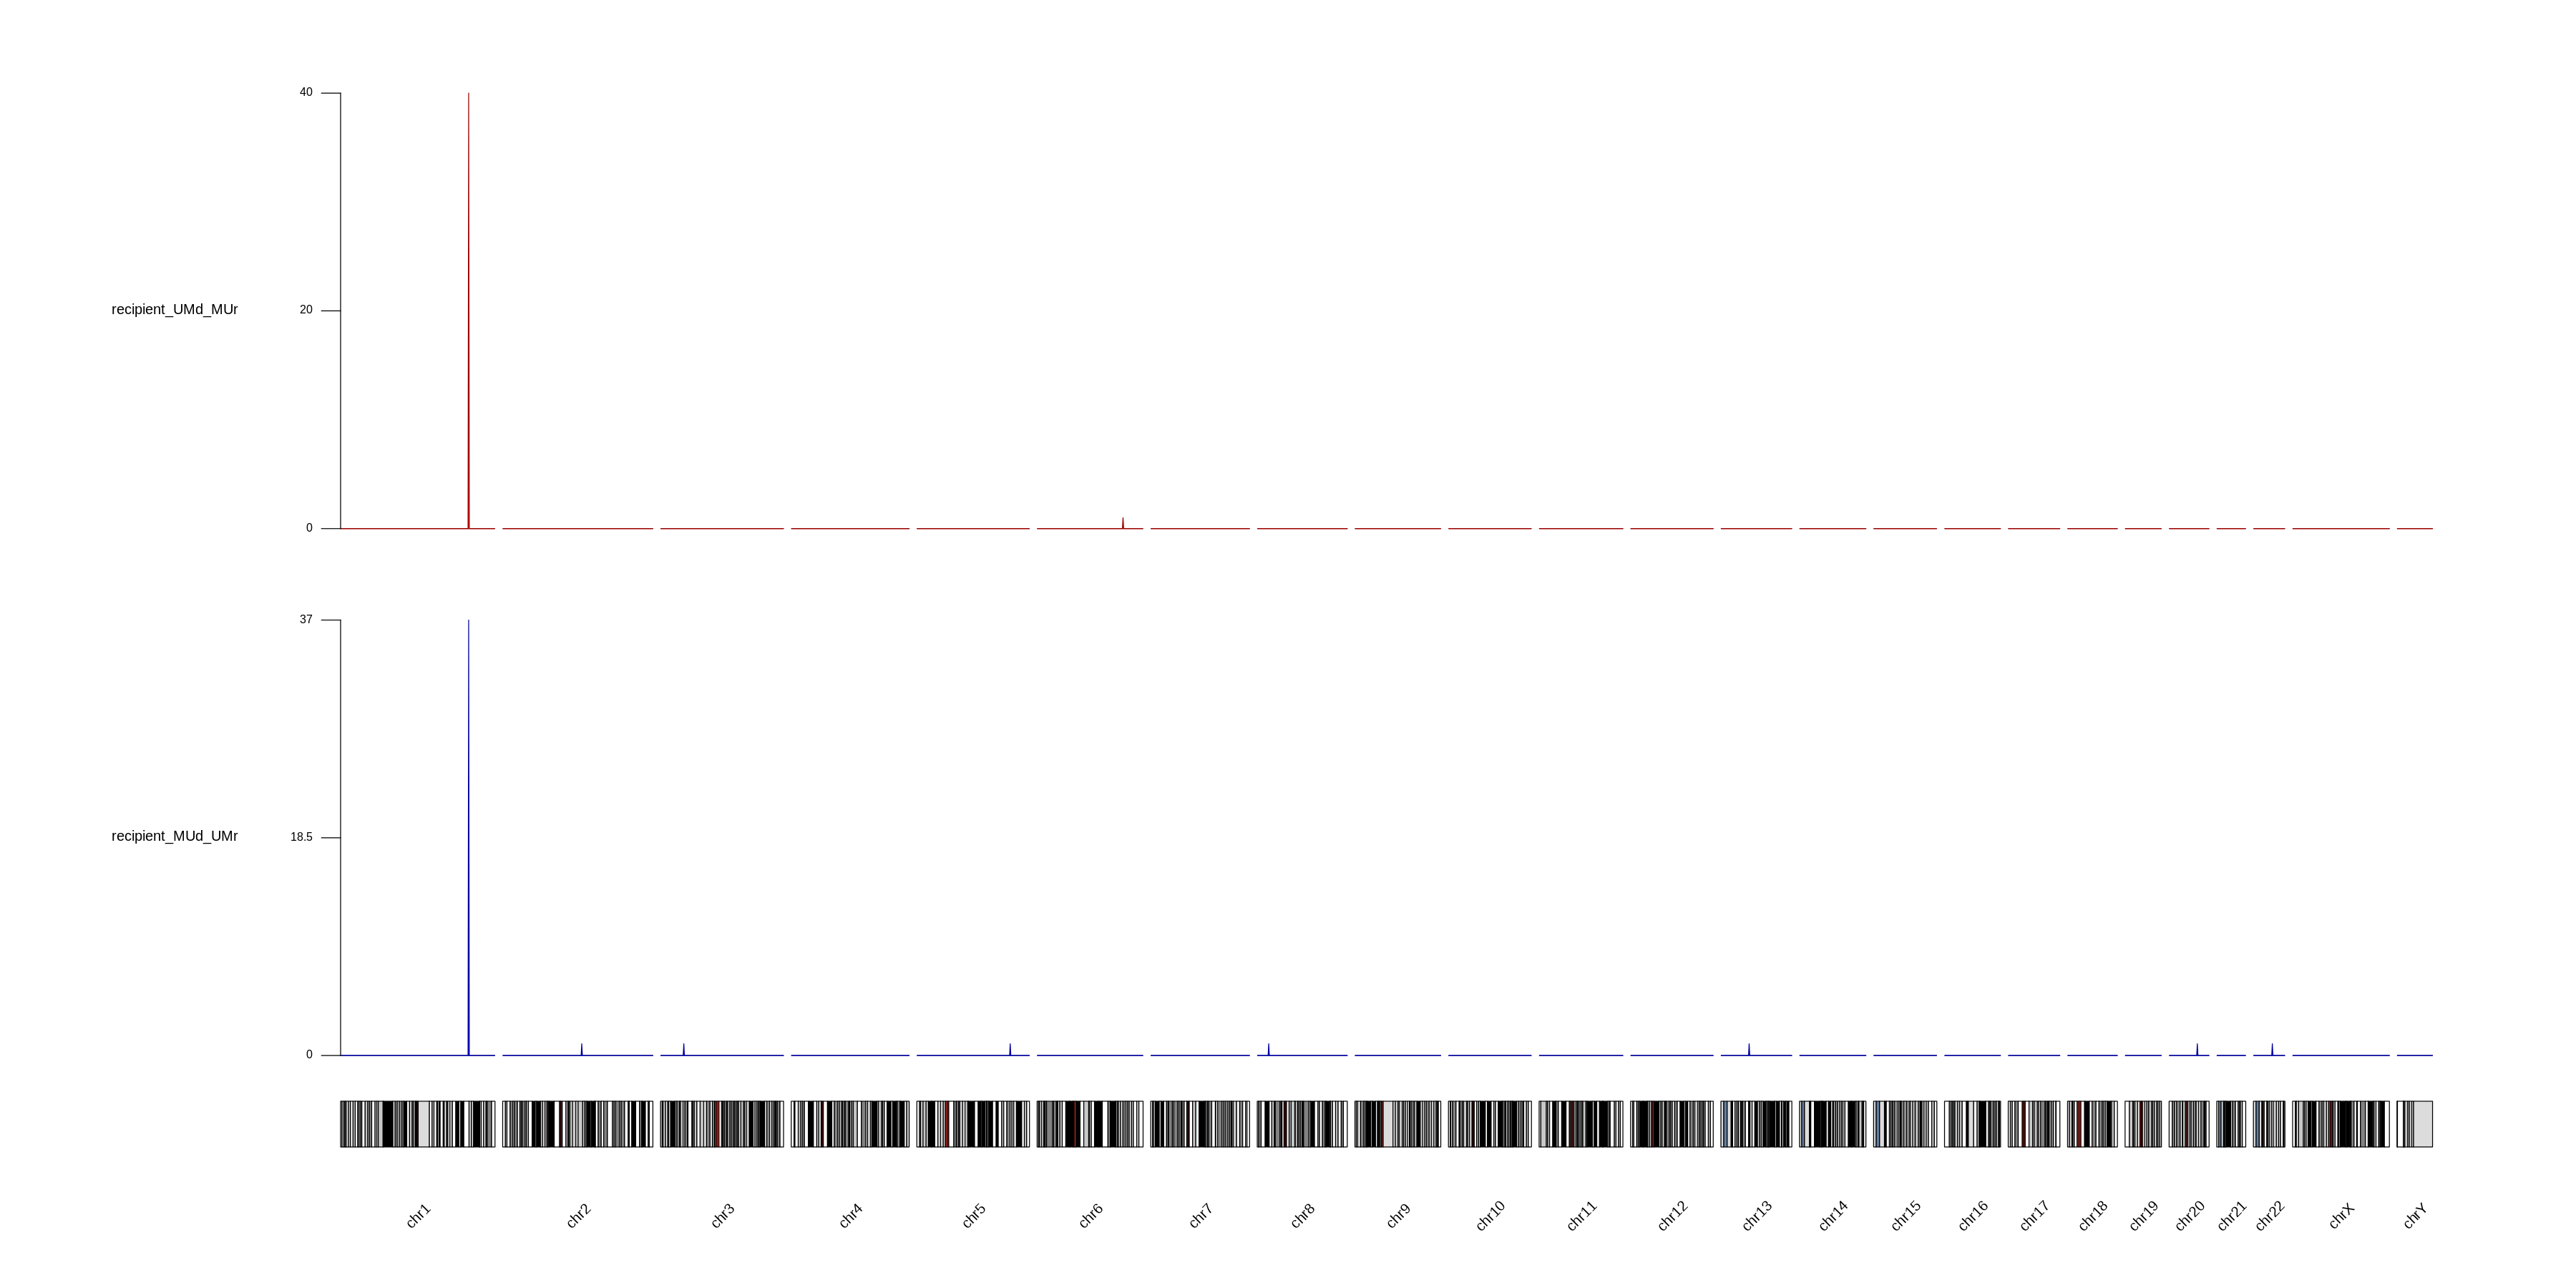

In [89]:
try(recipient_viz(reads_to_recipient_MUd_UMr.bed.gr, reads_to_recipient_UMd_MUr.bed.gr))

### reads_to_recipient_MUd_UMr

In [110]:
try(print_summary_table(reads_to_recipient_MUd_UMr.bed.gr, min_reads_count = 2))

[1] "Minimum Reads Count = 2"


group,chr,start,stop,number_of_reads
<int>,<fct>,<int>,<int>,<int>
2,chr1,206939232,206939466,9
5,chr1,206940489,206940587,12
6,chr1,206949933,206950040,5
7,chr1,206950086,206950244,7


### reads_to_recipient_UMd_MUr

In [111]:
try(print_summary_table(reads_to_recipient_UMd_MUr.bed.gr, min_reads_count = 2))

[1] "Minimum Reads Count = 2"


group,chr,start,stop,number_of_reads
<int>,<fct>,<int>,<int>,<int>
2,chr1,206939236,206939466,9
4,chr1,206940489,206940589,12
6,chr1,206949934,206950229,15
